# Choosing good biomarkers with the help of machine learning models in Scikit Learn

We are going to use the data extracted from the supplementary file of the article [Elias] which for each patient gives the expression levels of 192 different miRNAs calculated in transcripts per millions. To have more informations about this study, you can refer to the subsection "An example of potential pipeline" in the "Theoretical background".

Note: For a better redability of the code, some used functions have been placed in a package folder and can be accessible at https://github.com/aqm13/iGEM2021 . The data  used can also be found following the same link.

# Preprocessing the data

After importing the data from the [Elias] study, we have realized that it had also negative values which where replaced by the zero value, and a new colum has been added to their initial expression level data that classifies the patients into two classes: benign or borderline cases denoted by 0, and cancerous cases denoted by 1. 

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt

from igem.data import read_clean_classify_data

df=read_clean_classify_data('miRNA_cancer.csv', 'model_predictions.csv')
print("The number of patients and miRNAs used in the study are " + str((df.shape[0],df.shape[1]-1)))
df.head()

The number of patients and miRNAs used in the study are (179, 192)


,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c-5p,hsa-let-7d-3p,hsa-let-7d-5p,hsa-let-7e-5p,hsa-let-7f-5p,hsa-let-7g-5p,...,hsa-miR-2110,hsa-miR-3158-3p,hsa-miR-3613-5p,hsa-miR-3615,hsa-miR-4433b-3p,hsa-miR-4443,hsa-miR-4732-5p,hsa-miR-6842-3p,hsa-miR-7706,cancer
1,1.630462,4.186283,0.639502,3.939203,2.781000,2.231032,3.167665,1.804878,4.069749,4.142388,...,1.978597,1.868226,1.137093,2.138996,1.542967,0.899680,1.404557,1.528011,1.031705,1
2,1.939559,3.975204,1.181827,3.725716,2.693751,2.675460,2.970325,1.344445,4.000097,3.790741,...,2.143514,2.240902,1.405153,2.721675,0.283812,1.095915,1.372441,1.350387,1.791916,1
3,1.855097,3.970373,0.948315,3.798299,2.556362,2.545208,3.119561,1.508062,3.984547,3.763569,...,2.163956,1.685155,1.204889,2.727179,0.824308,1.314232,1.574649,1.247913,1.517369,0
4,1.927998,3.712432,1.064584,4.013500,2.535111,2.268920,2.739540,1.703044,3.670491,3.375069,...,1.464179,1.579903,1.009491,2.498544,1.181059,1.570979,1.604118,1.385318,1.331882,0
5,1.314039,3.908810,1.181827,3.612288,2.428277,2.526470,2.981463,1.728413,3.831841,3.426256,...,1.831698,1.571819,1.098613,2.580249,2.043460,1.063001,1.099556,1.350387,1.211932,1


# Feature selection

Each column or each miRNA is considered a feature. Since there are more features than individuals in the study and since we want to obtain a subsest of miRNAs, there is a need to reduce the number of features in the data. We do this by using three techniques: Pearson correlation, recursive feature elimination and lasso regularization, or by combining two together. 

In [2]:
from igem.feature_selection import pearson, lasso, rfe

#Feature selection using Pearson correlation
selected_pearson=pearson(df)
df_pearson = df[selected_pearson]
df_pearson['cancer']=df['cancer']

#Feature selection using recursive feature elimination
selected_rfe=rfe(df)
df_rfe=df[selected_rfe]
df_rfe['cancer']=df['cancer']

#Feature selection using lasso regularisation
selected_lasso=lasso(df)
df_lasso=df[selected_lasso]
df_lasso['cancer']=df['cancer']

#Feature selection using Pearson correlation followed by recursive feature elimination
selected_pearson_rfe=rfe(df_pearson)
df_pearson_rfe=df_pearson[selected_pearson_rfe]
df_pearson_rfe['cancer']=df_pearson['cancer']

#Feature selection using Pearson correlation followed by lasso regularisation
selected_pearson_lasso=lasso(df_pearson)
df_pearson_lasso=df_pearson[selected_pearson_lasso]
df_pearson_lasso['cancer']=df_pearson['cancer']


We can then count the numbers of features selected with each method, and we can see that the Person selection selects more than a half of the features, while the other methods select really few features, which is good for offering possible candidates for biomarkers.

In [3]:
selected_features = {
  'pearson' : selected_pearson,
  'rfe' : selected_rfe,
  'lasso' : selected_lasso,
  'pearson_rfe' : selected_pearson_rfe,
  'pearson_lasso' : selected_lasso,
}

pd.DataFrame({k:[len(v)] for k, v in selected_features.items()}, index=['count'])

,pearson,rfe,lasso,pearson_rfe,pearson_lasso
count,111,3,5,3,5


We can also compare the obtained miRNAs in each set, between the feature selection methods and see if there are some that appear more than once.  We have also chosen to compare the obtained features with our three methods, with the three features methods used in [Elias].

In [53]:
all_selected=set([])
for key in selected_features:
  if key!='pearson':
    all_selected=all_selected.union(set(selected_features[key]))

res=[]
for key in selected_features:
  res_item=[]
  for feature in all_selected:
    if (feature in selected_features[key]):
      res_item.append('X')
    else:
      res_item.append('')
  res.append(res_item)  


df_all_selected=pd.DataFrame(res)
df_all_selected.columns=all_selected
df_all_selected.index = [key for key in selected_features]


df_elias=pd.read_csv('features_elias.csv')
res=[]
for column in df_elias.columns:
  s_col=df_elias[column]
  res_row=[]
  for feature in all_selected:
    if (feature in s_col.values):
      res_row.append('X')
    else:
      res_row.append('')
  res.append(res_row)

df_cmp_elias=pd.DataFrame(res)
df_cmp_elias.columns=all_selected
df_cmp_elias.index=df_elias.columns

pd.concat([df_all_selected, df_cmp_elias])

,hsa-miR-2110,hsa-miR-1246,hsa-miR-203a,hsa-miR-30d-5p,hsa-miR-361-3p,hsa-miR-320d,hsa-miR-200c-3p,hsa-miR-584-5p
pearson,X,X,X,X,X,,X,X
rfe,X,,,,,X,X,
lasso,,,X,X,,X,X,X
pearson_rfe,,X,,,X,,X,
pearson_lasso,,,X,X,,X,X,X
Elias1,,X,X,X,,X,X,
Elias2,,,,,,X,X,
Elias3,,X,X,,,X,X,


We can see that "hsa-miR-200c-3p" has been selected by all of our feature selection methods, but also by all the methods used in the [Elias] article, so it might be a really good candidate for a biomarker.

# Machine learning models

Since we have prepared the data, and selected some interesting features, we can now fit our four selected models: the linear regression, the support vector machine, the neural network, and the gradient boosting tree. The used parameters and scoring function, can be seen quite clearly in the inputs below. For more details, refer to the package proposed at the beginning of the notebook.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from igem.models import Runner, InputModel

kwargs={'test_size':0.33, 'random_state':42}
inputs=[
  InputModel(
    model_class = LogisticRegression,
    params={'max_iter':1000},
    scoring_function_name='decision_function',
    label_name='Logistic'
  ),
  InputModel(
    model_class = SVC,
    params={'kernel': 'linear', 'random_state': 4},
    scoring_function_name='decision_function',
    label_name='SVM'
  ),
  InputModel(
    model_class = MLPClassifier,
    params={'hidden_layer_sizes': (9,9,9), 'max_iter': 10000, 'last_column':True},
    scoring_function_name='predict_proba',
    label_name='MLP'
  ),
  InputModel(
    model_class = HistGradientBoostingClassifier,
    params={'last_column':True},
    scoring_function_name='predict_proba',
    label_name='GB'
  )
]


# Classifier performance assesement

We can calculate the sensitivity and the specificity for each of our selected models for a given treashold, in order to obtain the coordinates for a ROC curve and calculate the AUC. 

In [61]:

runner_without=Runner(df, inputs, **kwargs)
res_without=runner_without.get_results()
auc_without={k:v.auc for k, v in res_without.items()}

runner_pearson=Runner(df_pearson, inputs, **kwargs)
res_pearson=runner_pearson.get_results()
auc_pearson={k:v.auc for k, v in res_pearson.items()}

runner_rfe=Runner(df_rfe, inputs, **kwargs)
res_rfe=runner_rfe.get_results()
auc_rfe={k:v.auc for k, v in res_rfe.items()}

runner_lasso=Runner(df_lasso, inputs, **kwargs)
res_lasso=runner_lasso.get_results()
auc_lasso={k:v.auc for k, v in res_lasso.items()}

runner_pearson_rfe=Runner(df_pearson_rfe, inputs, **kwargs)
res_pearson_rfe=runner_pearson_rfe.get_results()
auc_pearson_rfe={k:v.auc for k, v in res_pearson_rfe.items()}

runner_pearson_lasso=Runner(df_pearson_lasso, inputs, **kwargs)
res_pearson_lasso=runner_pearson_lasso.get_results()
auc_pearson_lasso={k:v.auc for k, v in res_pearson_lasso.items()}

Since the AUC is our chosen mode of comparison between the models we are going to compare directly the AUC for each of our models. 

In [63]:
df_auc=pd.DataFrame({
  'without' : auc_without,
  'pearson' : auc_pearson,
  'rfe' : auc_rfe,
  'lasso' : auc_lasso,
  'pearson_rfe' : auc_pearson_rfe,
  'pearson_lasso' : auc_pearson_lasso
})

pd.options.display.float_format = '{:,.3f}'.format
df_auc

,without,pearson,rfe,lasso,pearson_rfe,pearson_lasso
Logistic,0.761,0.799,0.804,0.826,0.851,0.798
SVM,0.785,0.787,0.798,0.795,0.837,0.765
MLP,0.571,0.732,0.801,0.799,0.836,0.790
GB,0.757,0.744,0.707,0.769,0.786,0.782


We can see that the feature selection method using the Pearson correlation followed by a recursive feature elimination gives a good AUC value. We can also plot the ROC curves for this feature selection method and note that they are similar in nature, and the AUC corresponding to each model doesn't vary greatly between the models.

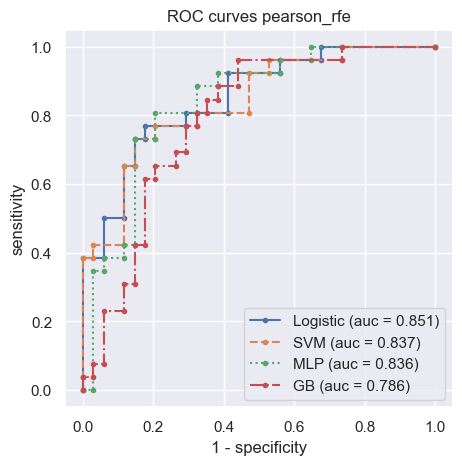

In [64]:
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

def plot_results(results,selection_name):
  plt.figure(figsize=(5, 5), dpi=100)

  linestyles = ['-', '--', ':', '-.']
  linestyle_index=0
  for name, res in results.items():
    plt.plot(res.fpr, res.tpr, linestyle=linestyles[linestyle_index], marker='.', label='{} (auc = %0.3f)'.format(name) % res.auc)
    linestyle_index+=1
    linestyle_index=linestyle_index % 4
  
  plt.xlabel('1 - specificity')
  plt.ylabel('sensitivity')
  plt.title(f'ROC curves {selection_name}')

  plt.legend()

  plt.show()

plot_results(res_pearson_rfe, 'pearson_rfe')

We can conclued by remembering that between the selected miRNAs for this feature selection method appears also the miRNA hsa-miR-200c-3p, which appears to be our best candidate for a good biomarker. It's worthy to mention, that this miRNA appeared all the other times we have run the code with different training and testing sets.